In [1]:
import fit_classes as fp
import numpy as np
import os
import pandas as pd

errors = []
ERROR = 1 
def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    name = str(file_path).split("/")[-1]
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    df.columns = df.columns.str.strip()

    SKIP1 = 1
    SKIP2_ =17
    SKIP2 = SKIP2_

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "superposition.txt")
    vals = []
    var = None
    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(int, line.strip().split(": ")[-1].strip("()").split(", ")))))

    check = False

    for var in vals:
        if var[0] == name:
            SKIP1, SKIP2 = var[1]
            check = True

    if not check:
        if True:
            values = (SKIP1, SKIP2)
            with open(file_p, "a") as file:
                file.write(f"{name}: {values}\n")

    x1 = df["Latest: Time (s)"].to_numpy()[::SKIP1]
    x2 = df["Latest: Time (s)"].to_numpy()[::SKIP2]
    y1 = df["Latest: Potential 1 (V)"].to_numpy()[::SKIP1]
    y2 = df["Latest: Potential 2 (V)"].to_numpy()[::SKIP2]
    dy1 = ERROR*np.ones_like(y1)
    dy2 = ERROR*np.ones_like(y2)

    data1 = fp.Data(x1, y1, dy1, name=str(file_path).split('/')[-1][0:-4] + '_1')
    data2 = fp.Data(x2, y2, dy2, name=str(file_path).split('/')[-1][0:-4]  + '_2')
    if not check:
        print(data2.name)
        data2.show()
    return data1, data2

        
def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    total_files += len([f for f in os.listdir(root)])

    current_file = 0
    data_list_input = []
    data_list = []
    for file in os.listdir(root):
        file_path = os.path.join(root, file)
        if os.path.isfile(file_path) and file.lower().endswith(".csv"):
            current_file += 1
            # os.system(f'echo "File: {current_file:>3}/{total_files}"')
            data1, data2 = data_from_file(file_path)
            data_list_input.append(data1)
            data_list.append(data2)
        
    if data_list:
        folder_data = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


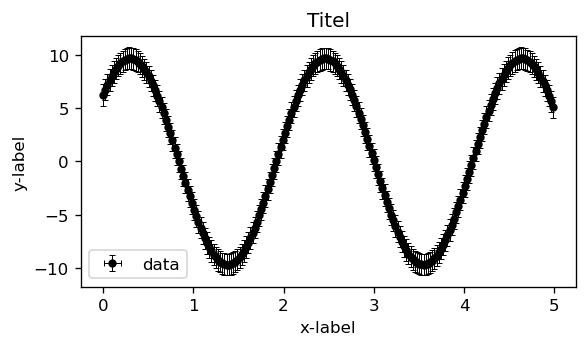

In [2]:
datadict = {}
for dataset in data_arrays:
    datadict[dataset.name[0:-2]] = dataset
    # if dataset[1].name == '2-5_190Hz_2':
    # print(dataset.name)
    # dataset.show()
         
datadict["2-3_250Hz"].show()

# Opgave 1

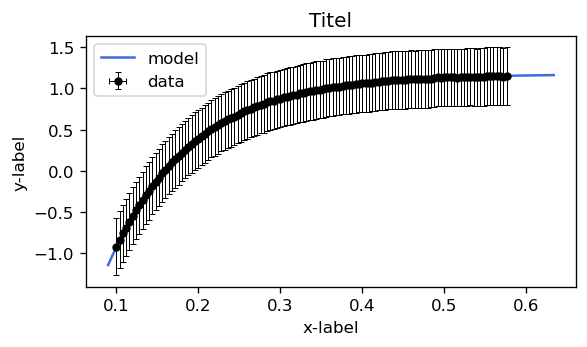

----------------------------------------------------------------------------------------------------------------
For parameter tau      :     $      0.10244 \pm      0.01382 $
For parameter a        :     $      1.17432 \pm      0.06315 $
----------------------------------------------------------------------------------------------------------------
Minimal χ² value       :     χ²_min           0.04179919
Reduced χ² value       :     χ²_red           0.00035423
P-value                :     p-value          1.00000000
----------------------------------------------------------------------------------------------------------------



In [3]:
ERROR = 0.35
dataset = fp.Data(datadict["2-1"].x[25:145], datadict["2-1"].y[25:145], ERROR*datadict["2-1"].dy[25:145])

def model_opgave1(params, x):
    tau,a = params
    return (1-np.exp(-(x-0.160)/tau))*a

dataset.fit(model_opgave1).show()
print(dataset.fit(model_opgave1))

# Opgave 2

In [8]:
ERROR = 0.01
files = []
files_new = []
for key in datadict:
    if key[0:3] == "2-2":
        files.append(fp.Data(datadict[key].x, datadict[key].y, ERROR*datadict[key].dy, name=datadict[key].name))

def sinus_model(params, x):
    A,f,phi,c = params
    return A*np.sin(2*np.pi*f*x + phi) + c

        
for dataset in files:
    A = 1.25
    f = 6
    phi = np.pi
    c = 0

    file_p = os.path.join(os.path.abspath(os.getcwd()), "data", "guesses_opgave2.txt")
    vals = []
    var = None
    check = True

    with open(file_p, "r") as file:
        for line in file:
            vals.append((line.strip().split(": ")[0],tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))))
    for var in vals:
        if var[0] == dataset.name:
            A, f, phi, c = var[1]
            check = False

    dataset_new = dataset.fit(sinus_model, initial_guess=[A, f, phi, c])
    files_new.append(dataset_new)
    if dataset_new.chi2_red > 10:
        check = False
            
    if check:
        values = tuple([_ for _ in dataset_new.minima])
        with open(file_p, "a") as file:
            file.write(f"{dataset.name}: {values}\n")
            # print(f"{dataset.name}: {values}")

    if dataset_new.chi2_red > 70:
        print(dataset.name)
        print(dataset_new)
        dataset_new.show(size=1, fit_guess=True)

In [10]:
print(files_new)

[<fit_classes.Fit object at 0x76b157322cf0>, <fit_classes.Fit object at 0x76b1575276e0>, <fit_classes.Fit object at 0x76b154fce8d0>, <fit_classes.Fit object at 0x76b1563eda30>, <fit_classes.Fit object at 0x76b154ffc7d0>, <fit_classes.Fit object at 0x76b1572af5c0>, <fit_classes.Fit object at 0x76b154fce450>, <fit_classes.Fit object at 0x76b1559d0c50>, <fit_classes.Fit object at 0x76b1572af6e0>, <fit_classes.Fit object at 0x76b1574376e0>, <fit_classes.Fit object at 0x76b1572af9e0>, <fit_classes.Fit object at 0x76b157234b00>, <fit_classes.Fit object at 0x76b157374cb0>, <fit_classes.Fit object at 0x76b15595a3f0>, <fit_classes.Fit object at 0x76b15758bef0>]


# Opgave 3

In [5]:
print("opgave3")

opgave3
